## Naive Modeling using Minimum Analysis

**Reference** : [Link](https://www.kaggle.com/kimchiwoong/simple-fast-check-xgboost-prediction-performance)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## 1. Loading the Dataset

### 1-1. Reducing Memory Usage via Downsizing Datatypes
Reducing memory usage by downsizing datatypes in the dataset is now a common practice since it speeds up the overall process :)

In [2]:
train_tr = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
test_tr = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')

In [3]:
def reduce_mem(df):
  start_mem=df.memory_usage().sum()/1024**2
  print('Initial Memory Usage : {:.2f} MB'.format(start_mem))
  for col in df.columns:
    col_type=df[col].dtype
    if col_type != object:
      mn, mx = df[col].min(), df[col].max()
      if str(col_type)[:3]=='int':
        if mn>np.iinfo(np.int8).min and mx<np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif mn>np.iinfo(np.int16).min and mx<np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif mn>np.iinfo(np.int32).min and mx<np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
      else:
        if mn>np.finfo(np.float16).min and mx<np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif mn>np.finfo(np.float32).min and mx<np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
  end_mem = df.memory_usage().sum()/1024**2
  print('Final Memory Usage : {:.2f} MB'.format(end_mem))
  print('Decreased by {:.2f}%'.format(100*(start_mem-end_mem)/start_mem))
  return df

In [4]:
print(train_tr.info())
print(train_id.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17         

In [5]:
train_tr = reduce_mem(train_tr)
train_id = reduce_mem(train_id)

Initial Memory Usage : 1775.15 MB
Final Memory Usage : 542.35 MB
Decreased by 69.45%
Initial Memory Usage : 45.12 MB
Final Memory Usage : 25.86 MB
Decreased by 42.68%


In [6]:
print(train_tr.info())
print(train_id.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float16(332), float32(44), int16(1), int32(2), int8(1), object(14)
memory usage: 542.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int32
id_01            144233 non-null float16
id_02            140872 non-null float32
id_03            66324 non-null float16
id_04            66324 non-null float16
id_05            136865 non-null float16
id_06            136865 non-null float16
id_07            5155 non-null float16
id_08            5155 non-null float16
id_09            74926 non-null float16
id_10            74926 non-null float16
id_11            140978 non-null float16
id_12            144233 non-null object
id_13            127320 non-null float16
id_14            80044 non-null float16
id_15            140985 non-null object
id_16            129

In [7]:
import gc
gc.collect()
test_tr = reduce_mem(test_tr)
test_id = reduce_mem(test_id)

Initial Memory Usage : 1519.24 MB
Final Memory Usage : 472.59 MB
Decreased by 68.89%
Initial Memory Usage : 44.39 MB
Final Memory Usage : 25.44 MB
Decreased by 42.68%


In [8]:
print(test_tr.info())
print(test_id.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float16(324), float32(52), int16(1), int32(2), object(14)
memory usage: 472.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
TransactionID    141907 non-null int32
id_01            141907 non-null float16
id_02            136976 non-null float32
id_03            66481 non-null float16
id_04            66481 non-null float16
id_05            134750 non-null float16
id_06            134750 non-null float16
id_07            5059 non-null float16
id_08            5059 non-null float16
id_09            74338 non-null float16
id_10            74338 non-null float16
id_11            136778 non-null float16
id_12            141907 non-null object
id_13            130286 non-null float16
id_14            71357 non-null float16
id_15            136977 non-null object
id_16            125747 non-n

### 1-2. Joining the Datasets

Joining the divided datasets eases the afterall process from EDA to predictive modeling.

In [9]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')
dataset = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)

In [10]:
train_len = len(train)
del train_tr, train_id, test_tr, test_id
gc.collect()

28

## 2. Exploratory Data Analysis

### 2-1. Missing Data

In [11]:
def missing_data(df):
    count = df.isnull().sum()
    percent = df.isnull().sum()/df.isnull().count()*100
    total = pd.concat([count, percent], axis=1, keys=['Count', 'Percent'])
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    total['dtypes'] = types
    return np.transpose(total)

In [12]:
missing_df = missing_data(dataset)
missing_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Count,0,506691,0,0,0,0,17587,4567,4663,8806,...,820324,948974,953271,947251,819269,819269,819269,819269,819490,863508
Percent,0,46.1791,0,0,0,0,1.60285,0.41623,0.424979,0.802566,...,74.7631,86.4881,86.8797,86.331,74.667,74.667,74.667,74.667,74.6871,78.6988
dtypes,int32,float64,int32,float16,object,int16,float16,float16,object,float16,...,object,float16,object,object,object,object,object,object,object,object


### 2-2. Numerical Columns

In [13]:
num_cols = [col for col in dataset.columns if dataset[col].dtype in ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']]
dataset[num_cols].describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.097231e+06,590540.000000,1.097231e+06,1.097231e+06,1.097231e+06,1079644.0,1092664.0,1088425.0,965916.0,965916.0,...,275335.0,95988.0,275224.0,274894.0,10218.0,1.023100e+04,9487.000000,10171.000,10210.0000,148257.0
mean,3.575333e+06,0.034990,1.640384e+07,NaN,9.925744e+03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,inf,inf,inf,inf,inf,NaN
std,3.544294e+05,0.183755,1.081612e+07,NaN,4.893776e+03,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,inf,6.304688e+00,2.835938,92.125,32.0625,0.0
min,2.987000e+06,0.000000,8.640000e+04,1.800537e-02,1.000000e+03,100.0,100.0,100.0,100.0,10.0,...,100.0,10.0,100.0,100.0,100.0,1.000000e+01,10.000000,100.000,100.0000,0.0
25%,3.261308e+06,0.000000,6.651887e+06,4.200000e+01,6.019000e+03,210.0,150.0,166.0,204.0,87.0,...,166.0,13.0,266.0,256.0,252.0,1.400000e+01,11.000000,321.000,121.0000,24.0
50%,3.535615e+06,0.000000,1.449162e+07,6.793750e+01,9.749000e+03,361.0,150.0,226.0,299.0,87.0,...,166.0,15.0,337.0,472.0,277.0,1.400000e+01,11.000000,321.000,147.0000,24.0
75%,3.895932e+06,0.000000,2.651323e+07,1.250000e+02,1.424750e+04,512.0,150.0,226.0,330.0,87.0,...,225.0,15.0,427.0,539.0,711.0,1.400000e+01,15.000000,360.000,173.7500,32.0
max,4.170239e+06,1.000000,3.421434e+07,3.193600e+04,1.839700e+04,600.0,232.0,237.0,540.0,102.0,...,229.0,29.0,671.0,661.0,854.0,4.400000e+01,26.000000,549.000,216.0000,48.0


### 2-3. Categorical Columns

In [14]:
cat_cols = [col for col in dataset.columns if dataset[col].dtype not in ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']]
dataset[cat_cols].describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,1097231,1092568,1092653,933583,273161,649492,649492,649492,578042,437117,...,148224,276907,143960,149980,277962,277962,277962,277962,277741,233723
unique,5,4,4,60,60,2,2,2,3,2,...,87,172,461,4,2,2,2,2,2,2799
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,...,Windows 10,mobile safari 11.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,800657,719649,824959,435803,118885,649436,588323,518244,357789,240155,...,42170,23655,33742,132185,149464,267353,215149,168980,159568,92710


In [15]:
for col in cat_cols:
    print('-'*25+'['+col+']'+'-'*25)
    print(dataset[[col, 'isFraud']].groupby(col).mean()*100)

-------------------------[ProductCD]-------------------------
             isFraud
ProductCD           
C          11.687269
H           4.766231
R           3.782594
S           5.899553
W           2.039939
-------------------------[card4]-------------------------
                   isFraud
card4                     
american express  2.869837
discover          7.728161
mastercard        3.433095
visa              3.475610
-------------------------[card6]-------------------------
                  isFraud
card6                    
charge card      0.000000
credit           6.678480
debit            2.426251
debit or credit  0.000000
-------------------------[P_emaildomain]-------------------------
                    isFraud
P_emaildomain              
aim.com           12.698413
anonymous.com      2.321747
aol.com            2.181060
att.net            0.743863
bellsouth.net      2.776323
cableone.net       1.886792
centurylink.net    0.000000
cfl.rr.com         0.000000
charter.net

## 3. Feature Engineering

In [16]:
print(dataset.shape)

(1097231, 434)


### 3-1. Adding Datetimes

In [17]:
import datetime

genesis = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
dataset['Date'] = dataset['TransactionDT'].apply(lambda x : genesis+datetime.timedelta(seconds=x))

In [18]:
dataset['Weekdays'] = dataset['Date'].dt.dayofweek
dataset['Days'] = dataset['Date'].dt.day
dataset['Hours'] = dataset['Date'].dt.hour

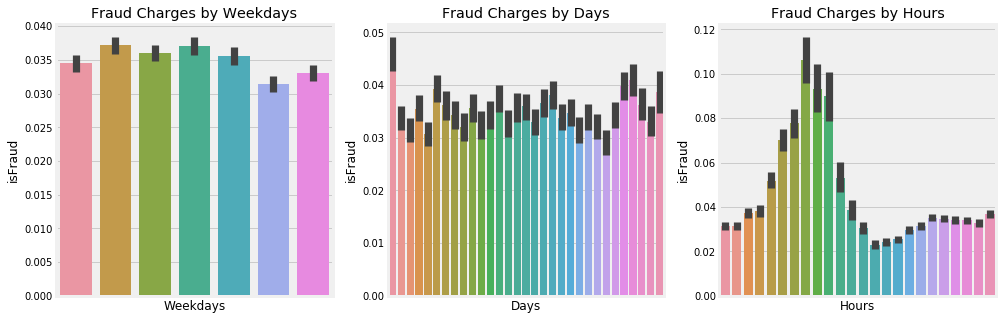

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

g = sns.barplot(dataset[dataset.index<train_len].Weekdays, train.isFraud, ax=ax[0])
ax[0].set_title('Fraud Charges by Weekdays')
plt.setp(g.get_xticklabels(), visible=False)

g = sns.barplot(dataset[dataset.index<train_len].Days, train.isFraud, ax=ax[1])
ax[1].set_title('Fraud Charges by Days')
plt.setp(g.get_xticklabels(), visible=False)

g = sns.barplot(dataset[dataset.index<train_len].Hours, train.isFraud, ax=ax[2])
ax[2].set_title('Fraud Charges by Hours')
plt.setp(g.get_xticklabels(), visible=False)

plt.show()

In [20]:
dataset.drop('Date', axis=1, inplace=True)

### 3-2. Handling Rare or Missing Email Domains

In [21]:
print(dataset['P_emaildomain'].value_counts().head())
print('Data type : {}'.format(dataset['P_emaildomain'].dtype))

gmail.com        435803
yahoo.com        182784
hotmail.com       85649
anonymous.com     71062
aol.com           52337
Name: P_emaildomain, dtype: int64
Data type : object


In [22]:
dataset.loc[(dataset.P_emaildomain!='gmail.com')&(dataset.P_emaildomain!='yahoo.com')&(dataset.P_emaildomain!='hotmail.com')&(dataset.P_emaildomain!='anonymous.com')&(dataset.P_emaildomain!='aol.com'), 'P_emaildomain'] = 'etc'

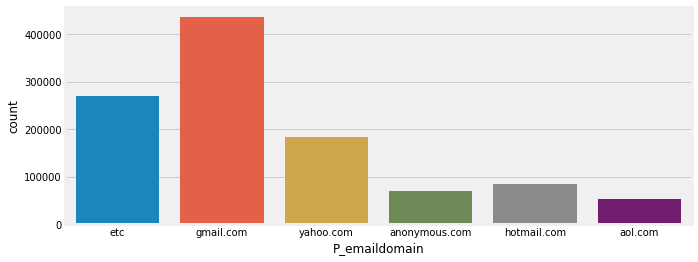

In [23]:
sns.countplot(dataset['P_emaildomain'])
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.show()

In [24]:
print(dataset['R_emaildomain'].value_counts().head())
print('Data type : {}'.format(dataset['P_emaildomain'].dtype))

gmail.com        118885
hotmail.com       53166
anonymous.com     39644
yahoo.com         21405
aol.com            7239
Name: R_emaildomain, dtype: int64
Data type : object


In [25]:
dataset.loc[(dataset.R_emaildomain!='gmail.com')&(dataset.R_emaildomain!='hotmail.com')&(dataset.R_emaildomain!='anonymous.com')&(dataset.R_emaildomain!='yahoo.com')&(dataset.R_emaildomain!='aol.com'), 'R_emaildomain'] = 'etc'

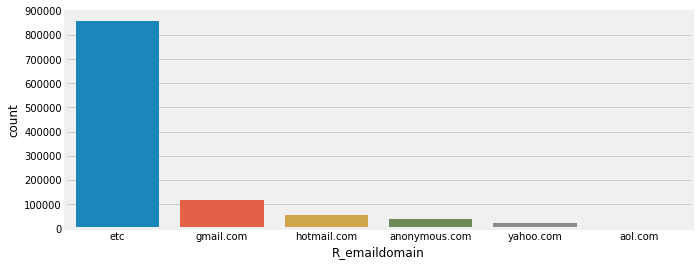

In [26]:
sns.countplot(dataset['R_emaildomain'])
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.show()

### 3-3. Operating Systems

In [27]:
top_os = dataset[['id_30', 'isFraud']].groupby(['id_30']).mean().sort_values(by=['isFraud'], ascending=False).head(10)
top_os.T

id_30,other,Android 5.1.1,Android 4.4.2,iOS 11.4.0,iOS 11.0.1,iOS 11.1.0,iOS 11.2.5,Android 7.1.2,iOS 11.2.2,Windows 8
isFraud,0.6,0.288571,0.253968,0.2,0.19685,0.177122,0.121667,0.121212,0.117517,0.116667


It seems obvious that fraud charges were mostly run by mobile devices or devices that run rare operating systems(denoted by *other*)

In [28]:
top_os = list(top_os.index)

In [29]:
all_os = list(dataset['id_30'].unique())
safe_os = [os for os in all_os if os not in top_os]

In [30]:
dataset.id_30.replace(safe_os, 'etc', inplace=True)

In [31]:
dataset[['id_30', 'isFraud']].groupby(['id_30']).mean().T

id_30,Android 4.4.2,Android 5.1.1,Android 7.1.2,Windows 8,etc,iOS 11.0.1,iOS 11.1.0,iOS 11.2.2,iOS 11.2.5,iOS 11.4.0,other
isFraud,0.253968,0.288571,0.121212,0.116667,0.034365,0.19685,0.177122,0.117517,0.121667,0.2,0.6


### 3-4. Browsers

In [32]:
top_browsers = dataset[['id_31', 'isFraud']].groupby(['id_31']).mean().sort_values(by=['isFraud'], ascending=False).head(10)
top_browsers.T

id_31,Mozilla/Firefox,icedragon,comodo,Lanix/Ilium,chrome 49.0 for android,opera,opera generic,chrome 52.0 for android,opera 49.0,samsung browser 5.4
isFraud,1.0,1.0,0.666667,0.666667,0.54717,0.481928,0.448718,0.381579,0.311594,0.302326


In [33]:
top_browsers = list(top_browsers.index)

In [34]:
all_browsers = list(dataset['id_31'].unique())
safe_browsers = [brw for brw in all_browsers if brw not in top_browsers]

In [35]:
dataset.id_31.replace(safe_browsers, 'etc', inplace=True)

In [36]:
dataset[['id_31', 'isFraud']].groupby('id_31').mean().sort_values(by='isFraud', ascending=False).T

id_31,Mozilla/Firefox,icedragon,Lanix/Ilium,comodo,chrome 49.0 for android,opera,opera generic,chrome 52.0 for android,opera 49.0,samsung browser 5.4,etc
isFraud,1.0,1.0,0.666667,0.666667,0.54717,0.481928,0.448718,0.381579,0.311594,0.302326,0.034627


### 3-5. Screen Sizes

Screen sizes can be factors to track specific device types

In [37]:
top_scrsz = dataset[['id_33', 'isFraud']].groupby(['id_33']).mean().sort_values(by=['isFraud'], ascending=False).head(15)
top_scrsz.T

id_33,1440x759,640x360,1916x901,1024x552,2076x1080,1920x975,1364x768,4500x3000,1024x600,1768x992,0x0,3201x1800,801x480,855x480,1365x767
isFraud,1.0,1.0,1.0,1.0,1.0,1.0,0.842105,0.666667,0.647727,0.6,0.5,0.4,0.390625,0.38,0.333333


In [38]:
top_scrsz = list(top_scrsz.index)

In [39]:
all_scrsz = dataset['id_33'].unique()
safe_scrsz = [s for s in all_scrsz if s not in top_scrsz]

In [40]:
dataset.id_33.replace(safe_scrsz, 'etc', inplace=True)

In [41]:
dataset[['id_33', 'isFraud']].groupby('id_33').mean().sort_values(by='isFraud', ascending=False).T

id_33,1024x552,1440x759,1916x901,1920x975,2076x1080,640x360,1364x768,4500x3000,1024x600,1768x992,0x0,3201x1800,801x480,855x480,1365x767,etc
isFraud,1.0,1.0,1.0,1.0,1.0,1.0,0.842105,0.666667,0.647727,0.6,0.5,0.4,0.390625,0.38,0.333333,0.03462


### 3-6. Device Information

In [42]:
top_dev = dataset[['DeviceInfo', 'isFraud']].groupby(['DeviceInfo']).mean().sort_values(by='isFraud', ascending=False).head(10)
top_dev.T

DeviceInfo,ZTE-Z835,Dream,SM-T285M,A5002,A466BG,SM-T530,Blade L3 Build/KOT49H,RNE-L23 Build/HUAWEIRNE-L23,SAMSUNG-SM-N900A,MotoG3-TE Build/MPD24.65-33
isFraud,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [43]:
top_dev = list(top_dev.loc[top_dev.isFraud>0.5].index)
top_dev

['ZTE-Z835',
 'Dream',
 'SM-T285M',
 'A5002',
 'A466BG',
 'SM-T530',
 'Blade L3 Build/KOT49H',
 'RNE-L23 Build/HUAWEIRNE-L23',
 'SAMSUNG-SM-N900A',
 'MotoG3-TE Build/MPD24.65-33']

In [44]:
all_dev = dataset['DeviceInfo'].unique()
safe_dev = [dev for dev in all_dev if dev not in top_dev]

In [45]:
dataset.DeviceInfo.replace(safe_dev, 'etc', inplace=True)

In [46]:
dataset[['DeviceInfo', 'isFraud']].groupby('DeviceInfo').mean().sort_values(by=['isFraud'], ascending=False).T

DeviceInfo,A466BG,A5002,Blade L3 Build/KOT49H,Dream,MotoG3-TE Build/MPD24.65-33,RNE-L23 Build/HUAWEIRNE-L23,SAMSUNG-SM-N900A,SM-T285M,SM-T530,ZTE-Z835,etc
isFraud,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.034928


### 3-7. One Hot Encoding

In [47]:
dataset_num = dataset.select_dtypes(exclude=['object'])
dataset_num.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_20,id_21,id_22,id_24,id_25,id_26,id_32,Weekdays,Days,Hours
0,2987000,0.0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0
1,2987001,0.0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0
2,2987002,0.0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0
3,2987003,0.0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0
4,2987004,0.0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,144.0,NaN,NaN,NaN,NaN,NaN,32.0,2,2,0


In [48]:
dataset_cat = dataset.select_dtypes(include=['object'])
dataset_cat.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,etc,etc,T,T,T,M2,F,...,etc,etc,etc,NaN,NaN,NaN,NaN,NaN,NaN,etc
1,W,mastercard,credit,gmail.com,etc,NaN,NaN,NaN,M0,T,...,etc,etc,etc,NaN,NaN,NaN,NaN,NaN,NaN,etc
2,W,visa,debit,etc,etc,T,T,T,M0,F,...,etc,etc,etc,NaN,NaN,NaN,NaN,NaN,NaN,etc
3,W,mastercard,debit,yahoo.com,etc,NaN,NaN,NaN,M0,T,...,etc,etc,etc,NaN,NaN,NaN,NaN,NaN,NaN,etc
4,H,mastercard,credit,gmail.com,etc,NaN,NaN,NaN,NaN,NaN,...,etc,etc,etc,match_status:2,T,F,T,T,mobile,etc


In [49]:
print('Added Columns : {}'.format(sum(dataset_cat.nunique().values)-len(dataset_cat.columns)))

Added Columns : 92


In [50]:
dataset_cat_new = pd.get_dummies(dataset_cat)
dataset = pd.concat([dataset_num, dataset_cat_new], axis=1)
dataset.shape

(1097231, 529)

In [51]:
dataset.drop('TransactionID', axis=1, inplace=True)
del dataset_num, dataset_cat
gc.collect()

2168

## 4. Predictive Modeling

In [52]:
dataset.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,DeviceInfo_A5002,DeviceInfo_Blade L3 Build/KOT49H,DeviceInfo_Dream,DeviceInfo_MotoG3-TE Build/MPD24.65-33,DeviceInfo_RNE-L23 Build/HUAWEIRNE-L23,DeviceInfo_SAMSUNG-SM-N900A,DeviceInfo_SM-T285M,DeviceInfo_SM-T530,DeviceInfo_ZTE-Z835,DeviceInfo_etc
0,0.0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,1
2,0.0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,1
4,0.0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,1


In [53]:
train = dataset[:train_len]
test = dataset[train_len:]

In [54]:
y = train.isFraud
X = train.drop('isFraud', axis=1)
test_X = test.drop('isFraud', axis=1)

In [55]:
np.unique(y)

array([0., 1.])

In [56]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

### 4-1. Extreme Gradient Boosting(XGB)

In [57]:
import xgboost as xgb

hyper = {
    'booster' : 'gbtree',
    'max_depth' : 6,
    'nthread' : -1,
    'num_class' : 1,
    'objective' : 'binary:logistic',
    'verbosity' : 0,
    'eval_metric' : 'auc',
    'eta' : 0.1,
    'tree_method' : 'gpu_hist',
    'min_child_weight' : 1,
    'colsample_bytree' : 0.8,
    'colsample_bylevel' : 0.8,
    'seed' : 0
}

dtrn = xgb.DMatrix(train_X, label=train_y, feature_names=X.columns)
dval = xgb.DMatrix(val_X, label=val_y, feature_names=X.columns)

_xgb = xgb.train(hyper, dtrn, num_boost_round=10000, evals=[(dtrn, 'train'), (dval, 'eval')], early_stopping_rounds=200, verbose_eval=200)

[0]	train-auc:0.783477	eval-auc:0.787451
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.948606	eval-auc:0.933561
[400]	train-auc:0.96568	eval-auc:0.946078
[600]	train-auc:0.97693	eval-auc:0.9543
[800]	train-auc:0.982893	eval-auc:0.958641
[1000]	train-auc:0.987404	eval-auc:0.962096
[1200]	train-auc:0.990503	eval-auc:0.964494
[1400]	train-auc:0.992886	eval-auc:0.966629
[1600]	train-auc:0.99468	eval-auc:0.968151
[1800]	train-auc:0.995828	eval-auc:0.969093
[2000]	train-auc:0.996754	eval-auc:0.96981
[2200]	train-auc:0.997372	eval-auc:0.970363
[2400]	train-auc:0.997848	eval-auc:0.970761
[2600]	train-auc:0.998333	eval-auc:0.971039
[2800]	train-auc:0.998686	eval-auc:0.971213
[3000]	train-auc:0.99899	eval-auc:0.9715
[3200]	train-auc:0.999224	eval-auc:0.97156
[3400]	train-auc:0.9994	eval-auc:0.971404
Stopping. Best iteration:
[3207]	train-auc:0.999235	eval-auc:0.971664



In [58]:
dtst = xgb.DMatrix(test_X, feature_names=X.columns)
preds_xgb = _xgb.predict(dtst)

### 4-2. Light Gradient Boosting Machine(LGBM)

In [59]:
import lightgbm as lgbm

hyper = {
    'num_leaves' : 500,
    'min_child_weight': 0.03,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.4,
    'min_data_in_leaf': 100,
    'objective': 'binary',
    'max_depth': 6,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'bagging_seed': 10,
    'metric': 'auc',
    'verbosity': 0,
    'reg_alpha': 0.4,
    'reg_lambda': 0.6,
    'random_state': 0
}

dtrain = lgbm.Dataset(train_X, label=train_y)
dvalid = lgbm.Dataset(val_X, label=val_y)
model = lgbm.train(hyper, dtrain, 10000, valid_sets=[dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.929949	valid_1's auc: 0.920268
[400]	training's auc: 0.94566	valid_1's auc: 0.932076
[600]	training's auc: 0.955731	valid_1's auc: 0.939638
[800]	training's auc: 0.963587	valid_1's auc: 0.945691
[1000]	training's auc: 0.969016	valid_1's auc: 0.949813
[1200]	training's auc: 0.973186	valid_1's auc: 0.95267
[1400]	training's auc: 0.977392	valid_1's auc: 0.955562
[1600]	training's auc: 0.980505	valid_1's auc: 0.957978
[1800]	training's auc: 0.983255	valid_1's auc: 0.959977
[2000]	training's auc: 0.985244	valid_1's auc: 0.961305
[2200]	training's auc: 0.987067	valid_1's auc: 0.962597
[2400]	training's auc: 0.988987	valid_1's auc: 0.964136
[2600]	training's auc: 0.990463	valid_1's auc: 0.965306
[2800]	training's auc: 0.991707	valid_1's auc: 0.966193
[3000]	training's auc: 0.99274	valid_1's auc: 0.967081
[3200]	training's auc: 0.993621	valid_1's auc: 0.967857
[3400]	training's auc: 0.994355	valid_1's auc: 0

In [60]:
preds_lgb = model.predict(test_X)

## 5. Submission

In [61]:
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
submission['isFraud'] = np.nan
submission.head()

,TransactionID,isFraud
0,3663549,NaN
1,3663550,NaN
2,3663551,NaN
3,3663552,NaN
4,3663553,NaN


In [62]:
submission['isFraud'] = (0.5*preds_xgb)+(0.5*preds_lgb)
submission.head()

,TransactionID,isFraud
0,3663549,0.000066
1,3663550,0.000034
2,3663551,0.000004
3,3663552,0.000177
4,3663553,0.000024


In [63]:
submission.to_csv('submission_mark_1.csv', index=False)